Nathan McLean,
ECO225: Project 2

# ECO225 Project 2: What is effect of the COVID-19 Pandemic on the 2020 US Presidential Election?

## Introduction

The United States Presidential election in 2020 has been called the most consequential in a lifetime. In the highest voter turnout ever recorded (in terms of the raw number of voters), former Vice President Joe Biden defeated the incumbent President Donald Trump. Among the many controversies of the Trump presidency, Trump's critics often cite his administration's handling of the COVID-19 pandemic as the key fatal flaw that defines his years in office. There is a hotly contested debate among political scholars and pundits as to whether or not the COVID-19 pandemic was what ultimately gave Biden the edge over Trump.

This project seeks to answer the question: what is the effect of the COVID-19 pandemic on the outcome of the 2020 US Presidential election?  To begin this analysis, I provide summary statistics and offer comments on a few key variables of interest. My dependent variable is the proportion of votes that Joe Biden received in the 2020 election within each county of the US.  The independent variables that I will look at most closely in this submission are the number of COVID-19 fatalities in each county (prior to November 1, 2020 – two days before the election), the total population of each county, and the proportion of votes that Hillary Clinton received in the 2016 election within each county.  In subsequent projects, I will expand on the number of variables studied in order to strengthen my analysis. 

The data I use for this project was assembled by Ethan Schacht in 2020 and is posted on Kaggle.com; the dataset is called "Election, COVID, and Demographic Data by County".  It provides county statistics for COVID-19 case and death counts, demographic and socioeconomic attributes, and election data for both the 2016 and 2020 Presedential elections.


In [164]:
#! pip install bokeh
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
#!pip install descartes #required for mapping

# Project 1

## Summary Statistics

In [165]:
# import the python packages used in the analysis
import numpy as num
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import polyfit
from statistics import mean
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline

from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
output_notebook()
import json

Loading BokehJS ...

Here, I read the data on Jupyter, and display it as a Data Frame before beginning my analysis and provision of summary statistics/figures.

In [166]:
df = pd.read_csv("county_statistics.csv") # read data

In [167]:
df.head() # explore the data, variable names

Unnamed: 0     county state  percentage16_Donald_Trump  \
0           0  Abbeville    SC                      0.629   
1           1     Acadia    LA                      0.773   
2           2   Accomack    VA                      0.545   
3           3        Ada    ID                      0.479   
4           4      Adair    IA                      0.653   

   percentage16_Hillary_Clinton  total_votes16  votes16_Donald_Trump  \
0                         0.346        10724.0                6742.0   
1                         0.206        27386.0               21159.0   
2                         0.428        15755.0                8582.0   
3                         0.387       195587.0               93748.0   
4                         0.300         3759.0                2456.0   

   votes16_Hillary_Clinton  percentage20_Donald_Trump  percentage20_Joe_Biden  \
0                   3712.0                      0.661                   0.330   
1                   5638.0                      0.795                   0.191   
2                   6737.0                      0.542                   0.447   
3                  75676.0                      0.504                   0.465   
4                   1127.0                      0.697                   0.286   

   ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  PrivateWork  \
0  ...   1.8          1.8         6.5         25.8    9505.0         78.8   
1  ...   1.6          2.2         2.5         27.6   24982.0         80.0   
2  ...   2.6          1.8         4.5         22.0   13837.0         74.6   
3  ...   1.5          2.8         6.9         20.4  214984.0         78.3   
4  ...   2.8          0.4         6.2         22.3    3680.0         73.8   

   PublicWork  SelfEmployed  FamilyWork  Unemployment  
0        13.3           7.8         0.1           9.4  
1        12.1           7.6         0.3           8.9  
2        18.1           7.1         0.2           5.4  
3        15.0           6.6         0.1           4.3  
4        15.3          10.4         0.5           3.0  

[5 rows x 51 columns]

In [168]:
df = df.drop(["Unnamed: 0"],axis = 1) # drop unwanted column
df = df.drop_duplicates() # drop duplicate values to clean data


In [169]:
df = df[df['percentage16_Hillary_Clinton'].notna()] 
df = df[df['percentage20_Joe_Biden'].notna()] 

In [170]:
df.head() # confirm that unwanted column has been removed

county state  percentage16_Donald_Trump  percentage16_Hillary_Clinton  \
0  Abbeville    SC                      0.629                         0.346   
1     Acadia    LA                      0.773                         0.206   
2   Accomack    VA                      0.545                         0.428   
3        Ada    ID                      0.479                         0.387   
4      Adair    IA                      0.653                         0.300   

   total_votes16  votes16_Donald_Trump  votes16_Hillary_Clinton  \
0        10724.0                6742.0                   3712.0   
1        27386.0               21159.0                   5638.0   
2        15755.0                8582.0                   6737.0   
3       195587.0               93748.0                  75676.0   
4         3759.0                2456.0                   1127.0   

   percentage20_Donald_Trump  percentage20_Joe_Biden  total_votes20  ...  \
0                      0.661                   0.330        12433.0  ...   
1                      0.795                   0.191        28425.0  ...   
2                      0.542                   0.447        16938.0  ...   
3                      0.504                   0.465       259389.0  ...   
4                      0.697                   0.286         4183.0  ...   

   Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  PrivateWork  \
0   1.8          1.8         6.5         25.8    9505.0         78.8   
1   1.6          2.2         2.5         27.6   24982.0         80.0   
2   2.6          1.8         4.5         22.0   13837.0         74.6   
3   1.5          2.8         6.9         20.4  214984.0         78.3   
4   2.8          0.4         6.2         22.3    3680.0         73.8   

   PublicWork  SelfEmployed  FamilyWork  Unemployment  
0        13.3           7.8         0.1           9.4  
1        12.1           7.6         0.3           8.9  
2        18.1           7.1         0.2           5.4  
3        15.0           6.6         0.1           4.3  
4        15.3          10.4         0.5           3.0  

[5 rows x 50 columns]

#### Assign variable names to access data frame columns more easily 

In [171]:
p_biden = df["percentage20_Joe_Biden"]
p_clinton = df["percentage16_Hillary_Clinton"]
cov_deaths = df["deaths"]
cov_cases = df["cases"]
population = df["TotalPop"]

#### Describe basic summary statistics for the variables under analysis

In [172]:
p_biden.describe() # basic summary stats for Biden 2020 proportion of vote by county

count    3086.00000
mean        0.32969
std         0.15824
min         0.03100
25%         0.20800
50%         0.29800
75%         0.41800
max         0.94000
Name: percentage20_Joe_Biden, dtype: float64

In [173]:
p_clinton.describe() # basic summary stats for Clinton 2016 proportion of vote by county

count    3086.000000
mean        0.315428
std         0.152480
min         0.031000
25%         0.204000
50%         0.283000
75%         0.397750
max         0.928000
Name: percentage16_Hillary_Clinton, dtype: float64

In [174]:
cov_deaths.describe() # basic summary stats for COVID-19 deaths by county

count    3046.000000
mean       72.733093
std       342.061979
min         0.000000
25%         3.000000
50%        11.000000
75%        36.000000
max      7404.000000
Name: deaths, dtype: float64

In [175]:
population.describe() # basic summary stats for population totals by county

count    3.086000e+03
mean     1.021980e+05
std      3.296527e+05
min      7.400000e+01
25%      1.108450e+04
50%      2.576650e+04
75%      6.710175e+04
max      1.010572e+07
Name: TotalPop, dtype: float64

There are a few things to note from the basic summary of the data above. In every percentile under analysis (as well as the mean) Biden (2020) outperformed Clinton (2016) in terms of the proportion of the vote they received in each county. The mean and median values for those two variables are quite close to one another. Also, there are 1379 more observations for Biden (2020) than there are for Clinton (2016); Schacht, who assembled the dataset, notes that this is in part due to the fact of changing counties in a couple of states.

For the population and COVID-19 deaths summaries it is immediately clear that the mean is substantially greater than the median. The maximum value is also much greater than the 75th percentile in each case.  This is an indication that the distribution of these variables may be highly positively skewed – I check on this with histograms subsequently.

#### Visual depictions of distributions of, and relationships between variables

Text(0.5, 1.0, 'Distribution of Joe Biden Vote Proportions by County')

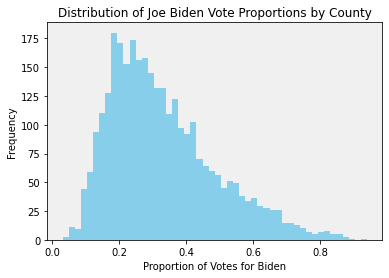

In [176]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(p_biden, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of the proportion of votes won by Biden by county
plt.xlabel('Proportion of Votes for Biden')
plt.ylabel('Frequency')
plt.title('Distribution of Joe Biden Vote Proportions by County')

The graph above illustrates the distribution of the proportion of votes won by Biden by county. Despite the fact that Biden won the election, the mean and median values of the vote proportions for him are clearly less than 50% (0.5). This is because these statistics are not weighted by population. Democrats typically perform best in counties with high population densities – Biden is no exception to this general rule.  This explains why Biden can have a good lot of counties where he only received approximately 20% of the vote and still win the election.

Text(0.5, 1.0, 'COVID-19 Deaths & Vote Proportions for Biden by County')

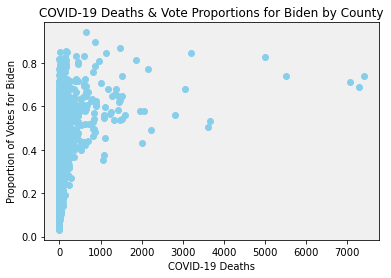

In [177]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.scatter(cov_deaths, p_biden, color = "skyblue") # draw a scatter plot illustrating the relationship between COVID-19 deaths and proportion of votes for Biden
plt.xlabel('COVID-19 Deaths')
plt.ylabel('Proportion of Votes for Biden')
plt.title("COVID-19 Deaths & Vote Proportions for Biden by County")

The graph above seems to depict a weak positive relationship between the proportion of votes for Biden and the number of COVID-19 deaths in a county. By the looks of it, the relationship between the two appears to be non-linear (following an almost logarithmic or square-root function type of shape). Overall, counties with high COVID-19 death counts seemed to favour Biden, however, there is a high concentration of areas with relatively lower COVID-19 deaths (as was stated in the summary statistics, the median is 10 deaths, and the 75th percentile is 35 deaths.  As a result, there are many counties with death totals in the range who favoured either candidate. 

Text(0.5, 1.0, 'Distribution of COVID-19 Deaths by County')

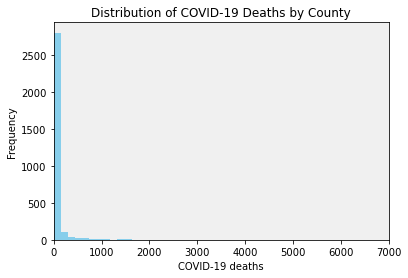

In [178]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.xlim(0, 7000)
plt.hist(cov_deaths, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of COVID-19 deaths by county
plt.xlabel('COVID-19 deaths')
plt.ylabel('Frequency')
plt.title('Distribution of COVID-19 Deaths by County')

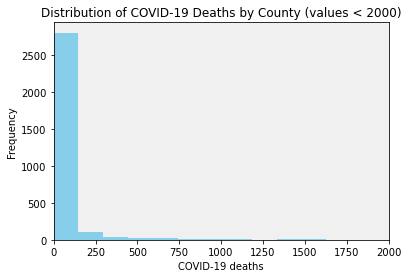

In [179]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(cov_deaths, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of COVID-19 deaths by county for values under 2000
plt.xlim(0, 2000)
plt.xlabel('COVID-19 deaths')
plt.ylabel('Frequency')
plt.title('Distribution of COVID-19 Deaths by County (values < 2000)')
plt.show()

The two graphs above illustrate the distribution of the number of COVID-19 deaths by county. As was expected (based on the summary statistics) the distribution is highly postively skewed. The distribution is in fact so postively skewed that the first graph made it difficult to visualize the distribution, so a second is provided with only values under 2000 (into the 99th percentile). As was aforementioned, this graph describes the fact that there are many counties with relatively few COVID-19 deaths (at the time of November 1, 2020), and a small proportion of counties with multitudes more deaths.

Text(0.5, 1.0, 'Populations & Vote Proportions for Biden by County')

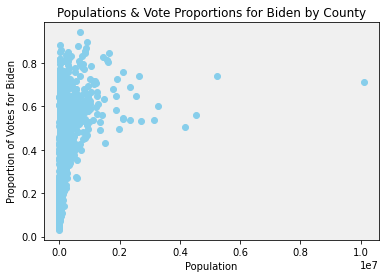

In [180]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.scatter(population, p_biden, color = "skyblue") # draw a scatter plot illustrating the relationship between population and proportion of votes for Biden
plt.xlabel('Population')
plt.ylabel('Proportion of Votes for Biden')
plt.title("Populations & Vote Proportions for Biden by County")

Much like the scatter plot with the COVID-19 deaths before, the graph above depicts a weak positive relationship between the proportion of votes for Biden and the number of COVID-19 deaths in a county. As it was in the prior case, the relationship between the two appears to be non-linear (following an almost logarithmic or square-root function type of shape). There are many more counties with relatively lower populations than there are with large ones.  One of the primary functions of studying population size as part of this analysis is that it likely has an effect on both the proportion of a county's voters who voted a particular candidate (Democrats typically do well in counties with large populations), and the number of COVID-19 deaths (high COVID-19 deaths associated with high population densities). If the size of the population is left unaccounted for in this analysis, it will be a confounder associated with potentially high endogeneity bias.  I have included a scatter plot below which illustrates the relationship between population and COVID-deaths (two of my independent variables); this demonstrates the importance of including it in the analysis.

Text(0.5, 1.0, 'Populations & COVID-19 Deaths by County')

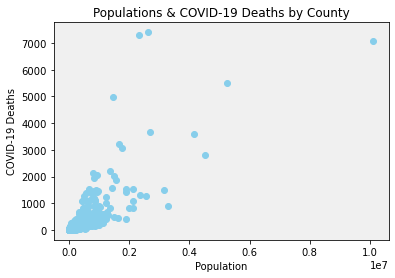

In [181]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.scatter(population, cov_deaths, color = "skyblue") # draw a scatter plot with population and COVID-19 deaths
plt.xlabel('Population')
plt.ylabel('COVID-19 Deaths')
plt.title("Populations & COVID-19 Deaths by County")


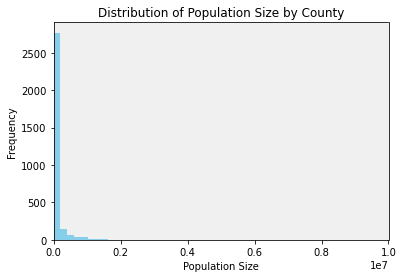

In [182]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(population, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of population by county
plt.xlim(0, 1e7)
plt.ylabel('Frequency')
plt.xlabel('Population Size')
plt.title('Distribution of Population Size by County')
bgcolour = (240/255, 240/255, 240/255)

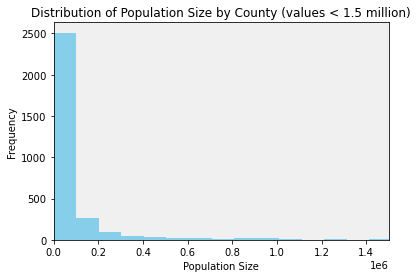

In [183]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(population, bins = 100, color="skyblue") # plot a histogram depicting the distribution of population by county for values under 1.5 million
plt.xlim(0, 1500000)
plt.xlabel('Population Size')
plt.ylabel('Frequency')
plt.title('Distribution of Population Size by County (values < 1.5 million)')
plt.show()

The two graphs above illustrate the distribution of county populations. Again, the distribution is highly postively skewed suchthat a second is valuable to help visualize it; in the second, values under 1.5 million people are provided (into the 99th percentile).  This explains the fact that many more counties have populations below the mean, while only a small proportion of counties hold populations well above it.

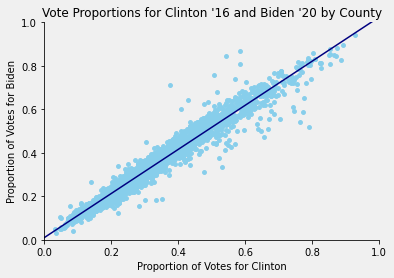

In [184]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
df.plot(kind="scatter", x="percentage16_Hillary_Clinton", y="percentage20_Joe_Biden", ax=ax, s=15, color="skyblue")
bgcolour = (240/255, 240/255, 240/255)
fig.set_facecolor(bgcolour)

# make axis titles for both vertical axis and horizontal axis, as well as the graph title
plt.xlabel('Proportion of Votes for Clinton')
plt.ylabel('Proportion of Votes for Biden')
plt.title("Vote Proportions for Clinton '16 and Biden '20 by County")

plt.xlim(0, 1)
plt.ylim(0, 1)

# plot the regression line of best fit for the scatter plot
lr = LinearRegression()
X = df["percentage16_Hillary_Clinton"].values.reshape(-1, 1)
y = df["percentage20_Joe_Biden"].values.reshape(-1, 1)
lr.fit(X, y)

# assign the colour of line of best fit as a shade of blue (under the RGB specification below)
colour = ("navy")
x = num.linspace(0.0, 1.0).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color=colour)

# format axis lines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The scatter plot above depicts relationship between the proportion of votes for Clinton in 2016 and Biden in 2020 by county.  There is a clear strong postive correlation between the two variables. This is to be expected; most people who voted Democrat in 2016 will also vote Democrat in 2020 (the same is, of course, true for Republicans). That is precisely the reason it is worthwhile to include this variable in the analysis. While the candidates and set of circumstances are different, if one is to isolate for the effect of the COVID-19 pandemic on the 2020 election, using the results of the previous election as a control can help identify differences where they exist – there is the potential for COVID-19 to have played a role in manifesting these differences. 

Text(0.5, 1.0, 'Distribution of Hillary Clinton Vote Proportions by County')

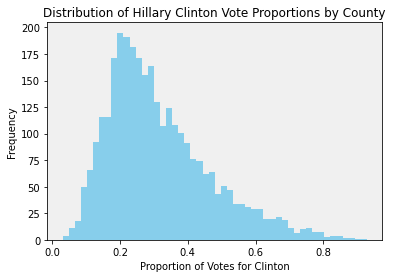

In [185]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(p_clinton, bins = 50, color="skyblue")  # plot a histogram depicting the distribution of %Clinton votes by county
plt.xlabel('Proportion of Votes for Clinton')
plt.ylabel('Frequency')
plt.title('Distribution of Hillary Clinton Vote Proportions by County')

The graph above illustrates the distribution of the proportion of votes won by Hillary Clinton in 2016 by county. Again, even though she won the popular vote, the mean and median values of the vote proportions for him are clearly less than 50% (0.5). There is positive skew in the distribution (albeit far less than the two other independent variabels previously studied). As was the case with the distribution of vote proportions for Biden by county, the counties with higher populations tend to lean the most towards voting for Clinton.

#### This is a function that, when applied, adds a new column to the data frame with a dummy variable indicating whether or not the county is in either Michigan, Wisconsin, Pennsylvania, Georgia, Arizona, or Nevada – the six key swing states Biden won. I discuss the value of this variable for future projects in the conclusion section.

In [186]:
def swing_function(state):
    # function coverts the categorical variable state into a dummy variable that identifies whether or not 
    # the state was one of the six key swing states that Biden won
    
    list_ss_biden_won = ['WI', 'MI', 'PA', 'GA', 'AZ', 'NV']
    
    if state in ['WI', 'MI', 'PA', 'GA', 'AZ', 'NV']:
        return 1
    else:
        return 0
    
df["swing_state_biden_won"] = df['state'].apply(swing_function)


In [187]:
df.head() # confirm that new column has been added

county state  percentage16_Donald_Trump  percentage16_Hillary_Clinton  \
0  Abbeville    SC                      0.629                         0.346   
1     Acadia    LA                      0.773                         0.206   
2   Accomack    VA                      0.545                         0.428   
3        Ada    ID                      0.479                         0.387   
4      Adair    IA                      0.653                         0.300   

   total_votes16  votes16_Donald_Trump  votes16_Hillary_Clinton  \
0        10724.0                6742.0                   3712.0   
1        27386.0               21159.0                   5638.0   
2        15755.0                8582.0                   6737.0   
3       195587.0               93748.0                  75676.0   
4         3759.0                2456.0                   1127.0   

   percentage20_Donald_Trump  percentage20_Joe_Biden  total_votes20  ...  \
0                      0.661                   0.330        12433.0  ...   
1                      0.795                   0.191        28425.0  ...   
2                      0.542                   0.447        16938.0  ...   
3                      0.504                   0.465       259389.0  ...   
4                      0.697                   0.286         4183.0  ...   

   OtherTransp  WorkAtHome  MeanCommute  Employed  PrivateWork  PublicWork  \
0          1.8         6.5         25.8    9505.0         78.8        13.3   
1          2.2         2.5         27.6   24982.0         80.0        12.1   
2          1.8         4.5         22.0   13837.0         74.6        18.1   
3          2.8         6.9         20.4  214984.0         78.3        15.0   
4          0.4         6.2         22.3    3680.0         73.8        15.3   

   SelfEmployed  FamilyWork  Unemployment  swing_state_biden_won  
0           7.8         0.1           9.4                      0  
1           7.6         0.3           8.9                      0  
2           7.1         0.2           5.4                      0  
3           6.6         0.1           4.3                      0  
4          10.4         0.5           3.0                      0  

[5 rows x 51 columns]

# Project 2

## The Message

In [215]:
swingstate_df = df.query("swing_state_biden_won == 1")
pd.options.mode.chained_assignment = None

In [218]:
swingstate_df['deaths_pc'] = swingstate_df.apply(lambda row: row["deaths"] / row["TotalPop"], axis=1)

In [219]:
swingstate_df.head()

county state  percentage16_Donald_Trump  percentage16_Hillary_Clinton  \
17    Adams    PA                      0.663                         0.299   
19    Adams    WI                      0.592                         0.374   
30   Alcona    MI                      0.680                         0.280   
36    Alger    MI                      0.573                         0.368   
38  Allegan    MI                      0.613                         0.325   

    total_votes16  votes16_Donald_Trump  votes16_Hillary_Clinton  \
17        47138.0               31249.0                  14077.0   
19        10107.0                5983.0                   3780.0   
30         6179.0                4201.0                   1732.0   
36         4513.0                2585.0                   1663.0   
38        55153.0               33812.0                  17932.0   

    percentage20_Donald_Trump  percentage20_Joe_Biden  total_votes20  ...  \
17                      0.663                   0.322        56627.0  ...   
19                      0.623                   0.366        11818.0  ...   
30                      0.686                   0.303         7063.0  ...   
36                      0.587                   0.400         5135.0  ...   
38                      0.616                   0.364        67182.0  ...   

    WorkAtHome  MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  \
17         3.8         27.6   50561.0         83.4        10.7           5.6   
19         6.0         28.3    7530.0         80.7        11.9           7.3   
30         5.3         24.0    3357.0         78.3        14.0           7.5   
36         8.0         21.3    3160.0         77.1        17.6           5.3   
38         4.1         23.9   54028.0         86.3         7.7           5.9   

    FamilyWork  Unemployment  swing_state_biden_won  deaths_pc  
17         0.2           4.9                      1   0.000305  
19         0.2           8.1                      1   0.000249  
30         0.2           9.3                      1   0.000288  
36         0.0           6.9                      1   0.000108  
38         0.2           3.6                      1   0.000061  

[5 rows x 52 columns]

In [221]:
p_biden_2 = swingstate_df["percentage20_Joe_Biden"]
p_clinton_2 = swingstate_df["percentage16_Hillary_Clinton"]
cov_deaths_2 = swingstate_df["deaths"]
population_2 = swingstate_df["TotalPop"]
d_pc = swingstate_df["deaths_pc"]

Text(0.5, 1.0, 'Distribution of Joe Biden Vote Proportions by County')

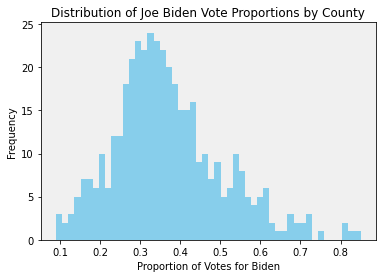

In [222]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(p_biden_2, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of the proportion of votes won by Biden by county
plt.xlabel('Proportion of Votes for Biden')
plt.ylabel('Frequency')
plt.title('Distribution of Joe Biden Vote Proportions by County')

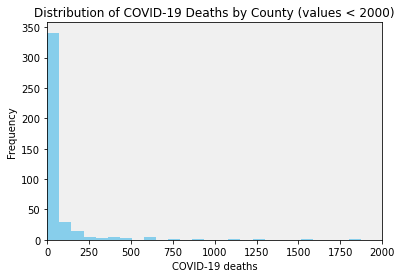

In [201]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.hist(cov_deaths_2, bins = 50, color = "skyblue") # plot a histogram depicting the distribution of COVID-19 deaths by county for values under 2000
plt.xlim(0, 2000)
plt.xlabel('COVID-19 deaths')
plt.ylabel('Frequency')
plt.title('Distribution of COVID-19 Deaths by County (values < 2000)')
plt.show()

In [227]:
d_pc.describe()

count    413.000000
mean       0.000668
std        0.000688
min        0.000000
25%        0.000207
50%        0.000459
75%        0.000872
max        0.005077
Name: deaths_pc, dtype: float64

Text(0.5, 1.0, 'COVID-19 Deaths & Vote Proportions for Biden by County')

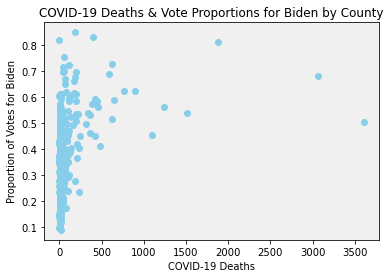

In [202]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.scatter(cov_deaths_2, p_biden_2, color = "skyblue") # draw a scatter plot illustrating the relationship between COVID-19 deaths and proportion of votes for Biden
plt.xlabel('COVID-19 Deaths')
plt.ylabel('Proportion of Votes for Biden')
plt.title("COVID-19 Deaths & Vote Proportions for Biden by County")

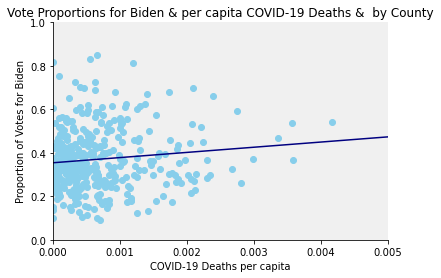

In [229]:
bgcolour = (240/255, 240/255, 240/255) # assign background colour to grey, and subsequently scatter plot colour to aqua
fig, ax = plt.subplots()
ax.set_facecolor(bgcolour)
plt.scatter(d_pc, p_biden_2, color = "skyblue") # draw a scatter plot illustrating the relationship between COVID-19 deaths and proportion of votes for Biden
plt.xlabel('COVID-19 Deaths per capita')
plt.ylabel('Proportion of Votes for Biden')
plt.title("Vote Proportions for Biden & per capita COVID-19 Deaths &  by County")

plt.xlim(0, .005)
plt.ylim(0, 1)

# plot the regression line of best fit for the scatter plot
lr = LinearRegression()
X = d_pc.values.reshape(-1, 1)
y = p_biden_2.values.reshape(-1, 1)
lr.fit(X, y)

# assign the colour of line of best fit as a shade of blue (under the RGB specification below)
colour = ("navy")
x = num.linspace(0.0, 1.0).reshape(-1, 1)
y_pred = lr.predict(x)
ax.plot(x, y_pred, color=colour)

# format axis lines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Mapping: Visualizing the Data

In [131]:
county_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_5m.zip")
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

# in order to make the map more easily readable, eliminate all values from state and county files not in continental US
r_st = ["78", "72", "69", "66", "60", "15", "02"]
r_cty = ["AK", "AS", "GU", "HI", "MP", "PR", "VI"] # locates locations outside of the continental US

state_df = state_df[~state_df["STUSPS"].isin(r_cty)]
county_df = county_df[~county_df["STATEFP"].isin(r_st)]

merged_df = county_df.merge(df, left_on = "NAME", right_on = "county", how = "inner")

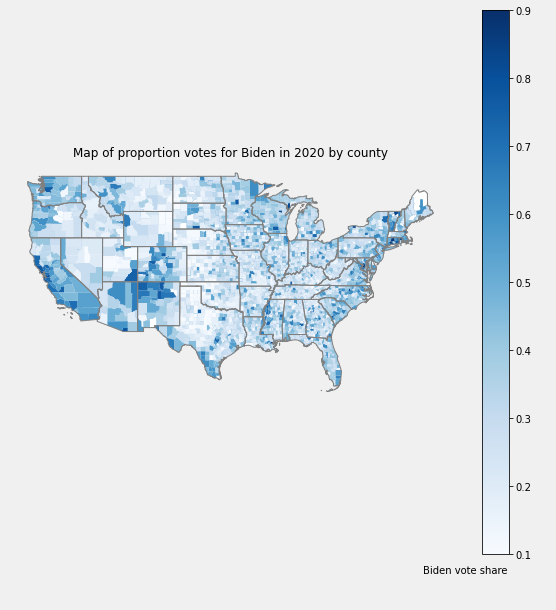

In [132]:
fig, gax = plt.subplots(figsize = (10, 10))
fig.set_facecolor(bgcolour)
ax.set_facecolor(bgcolour)

county_df.plot(ax=gax, color = "white", edgecolor= "None")
merged_df.plot(
    ax=gax, edgecolor= "None", column="percentage20_Joe_Biden", cmap = "Blues",legend=True, vmin=0.1, vmax=.9)
state_df.plot(ax=gax, edgecolor="grey", color="None")

gax.annotate('Biden vote share',xy=(0.76, 0.06),  xycoords='figure fraction')

plt.axis('off')
gax.set_title("Map of proportion votes for Biden in 2020 by county")

plt.show()


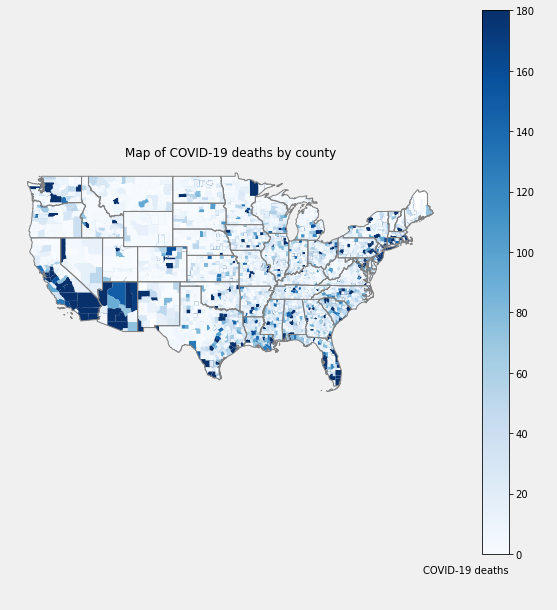

In [133]:
fig, gax = plt.subplots(figsize = (10, 10))
fig.set_facecolor(bgcolour)
ax.set_facecolor(bgcolour)
county_df.plot(ax=gax, color = "white", edgecolor= "None")
merged_df.plot(
    ax=gax, edgecolor= "None", column="deaths", cmap = "Blues",legend=True, vmin=0, vmax=180)
state_df.plot(ax=gax, edgecolor="grey", color="None")

gax.annotate('COVID-19 deaths',xy=(0.76, 0.06),  xycoords='figure fraction')

plt.axis('off')
gax.set_title("Map of COVID-19 deaths by county")

plt.show()

In [134]:
georgia_df = county_df.query("STATEFP == '13'")

In [135]:
georgia_results = georgia_df.merge(df, left_on="NAME", right_on="county", how="inner")

In [142]:
interactive_df =GeoJSONDataSource(geojson=georgia_results.to_json())

### Interactive Map for Clinton 2016 Proportion

In [147]:
color_mapper = LinearColorMapper(palette = brewer['Blues'][9], low = 0.1, high = 0.9)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('County','@county'),('Proportion Biden', '@percentage20_Joe_Biden'),
                               ('COVID-19 Deaths','@deaths')])
p = figure(title="Proportion of votes for Biden by county in Georgia", tools=[hover])
p.patches("xs","ys",source=interactive_df,
          fill_color = {'field' :'percentage20_Joe_Biden', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
                              
show(p)

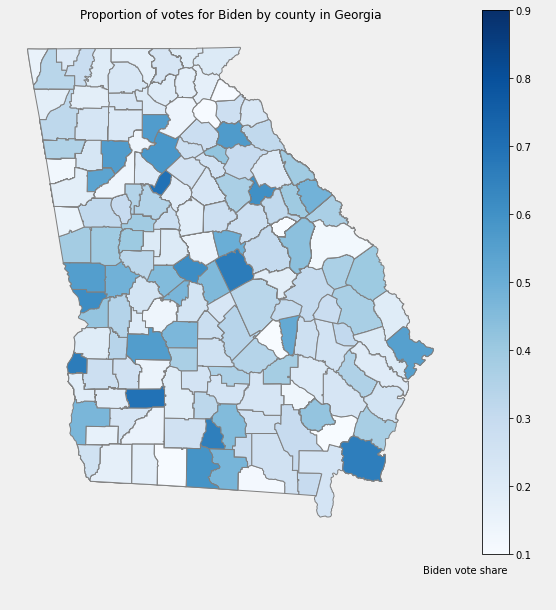

In [145]:
fig, gax = plt.subplots(figsize = (10,10))
fig.set_facecolor(bgcolour)
ax.set_facecolor(bgcolour)

georgia_results.plot(
    ax=gax, edgecolor='grey', column='percentage20_Joe_Biden', legend=True, cmap='Blues',
    vmin=0.1, vmax=.9 
)

gax.annotate('Biden vote share',xy=(0.76, 0.06),  xycoords='figure fraction')

plt.axis('off')

gax.set_title('Proportion of votes for Biden by county in Georgia')

plt.show()

### Interactive Map for Clinton 2016 Proportion

In [148]:
color_mapper = LinearColorMapper(palette = brewer['Blues'][9], low = 0.1, high = 0.9)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
hover = HoverTool(tooltips = [ ('County','@county'),('Proportion Clinton', '@percentage16_Hillary_Clinton'),
                               ('Proportion Biden', '@percentage20_Joe_Biden')])
p = figure(title="Proportion of votes for Clinton by county in Georgia", tools=[hover])
p.patches("xs","ys",source=interactive_df,
          fill_color = {'field' :'percentage16_Hillary_Clinton', 'transform' : color_mapper})
p.add_layout(color_bar, 'below')
                              
show(p)

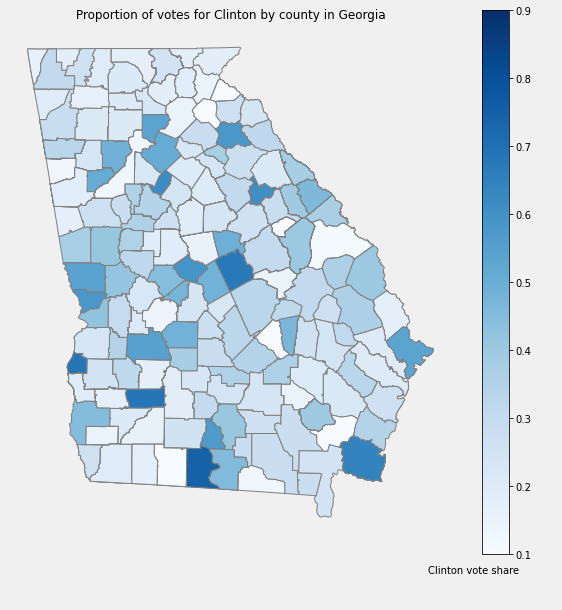

In [149]:
fig, gax = plt.subplots(figsize = (10,10))
fig.set_facecolor(bgcolour)
ax.set_facecolor(bgcolour)

georgia_results.plot(
    ax=gax, edgecolor='grey', column='percentage16_Hillary_Clinton', legend=True, cmap='Blues',
    vmin=0.1, vmax=.9 
)

gax.annotate('Clinton vote share',xy=(0.76, 0.06),  xycoords='figure fraction')

plt.axis('off')

gax.set_title('Proportion of votes for Clinton by county in Georgia')

plt.show()

## Conclusion & Future Steps

To conclude, this project provides the basis for an analysis into the effect of the COVID-19 pandemic on the outcome of the 2020 US presidential election. Early figures regarding the distributions of, and relationships between the independent and dependent variable give reason to believe that, equipped with the proper identification strategy, there may be the opportunity to isolate the causal effect of COVID-19 on the election.

In terms of future steps, several come to mind. First, I would like to go beyond simply looking at the difference in the proportion who voted for Biden as compared to the 2016 election, and examine any possible influences of increases in voter turnout.  The sizeable increase in turnout in counties that voted overwhelmingly for Democrats in both elections was a determining factor of the outcome; it is worthwhile to see how much of this increase in turnout may have been induced by COVID-19. I would also like to examine other possible independent variables to use as controls – the data is rich with demographic and socioeconomic variables, and I will experiment to see which ones are best suited to this particular analysis.

Moreover, the US Presidential Election is conducted under the framework of the Electoral College. By extension, certain so-called "swing states" where vote totals are likely to be close are made especially valuable. The fact that Biden flipped six of these swing states (Arizona, Georgia, Michigan, Nevada, Pennsylvania, and Wisconsin) was critical to securing his victory.  Because of this, I will create a group within the data that isolates these six states – the primary determinants of the outcome of the 2020 election - and attempt to identify what role, if any, COVID-19 played in influencing the results.